# Introduction to Machine Learning 2021 - Final Project

## Submission details - Group 2:
- Ben Mali - 204148225
- Doron Shapira - 316208032 
- Ariel Regev - 321776627

## Quick Access

- <a href="#Import-libraries">Import libraries</a>
- <a href="#Exploration">Explortaion</a>
- <a href="#Pre-Processing">Pre Processing</a> 
- <a href="#Evaluation">Evaluation</a>
- <a href="#Models">Models</a>
- <a href="#Test-prediction">Test prediction</a>
- <a href="#Additional-attempt">Additional attempt</a>
- <a href="#Weighted-accuracy">Weighted accuracy</a>

# Import libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# ML Models
from classifiers.KNN import knn
from classifiers.ANN import ann
from classifiers.SVM import svm
from classifiers.LogisticRegression import logistic_regression

from scalers.CustomMinMax import CustomMinMax


# Evaluation

from outliers import remove_outlier_stddev


from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import KFold


from graphs.AUC import AUC
from graphs.ConfusionMatrix import ConfusionMatrix


from processing.test_process import write_csv, predict_test
import numpy as np

from outliers.remove_outlier_stddev import remove_outlier_stddev

from sklearn.metrics import roc_curve

from helper.feature_classfier import classify_features


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from imputers.ChoiceImputer import ChoiceImputer
from imputers.DistributionImputer import DistributionImputer
from processing.feature_selection import process_feature_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


from sklearn.metrics import log_loss
from processing.basic_process import basic_process
from processing.OneHotEncoder import OneHotEncoder
from scalers.CustomMinMax import CustomMinMax

import csv


In [2]:
def get_non_binary_cols(data):
    """
    get the indexes of the non-binary, numeric columns
    we will use this function to scale on these columns
    :return: list of indexes
    """
    num_cols = list(map(str.strip, data._get_numeric_data().columns))[:-1]
    indexes = []

    for feature in data[num_cols]:
        values = [x != 1 and x != 0 and not pd.isnull(x) for x in data[feature]]
        if any(values):
            indexes.append(feature)
    return indexes


def classify_features(data):
    """
    get classifications for our data set
    :return: dictionary of class: [list of features that belong to this class]
    """
    classes = {"categorical": [],
               "binary": [],
               "numerical": []
               }
    features = set(data.columns)
    num_cols = list(map(str.strip, data._get_numeric_data().columns))[:-1]
    classes["categorical"] = sorted(features - set(num_cols))
    indexes = []
    for feature in data[num_cols]:
        values = [x != 1 and x != 0 and not pd.isnull(x) for x in data[feature]]
        if any(values):
            indexes.append(feature)
    classes["numerical"] = indexes
    classes["binary"] = sorted(set(num_cols) - set(indexes))
    return classes


# Import train data

In [3]:
train_set = pd.read_csv('train.csv')

# Exploration

#### We'll explore the data by showing statistics, data types, and correlations among the features.
#### In addition, we'll plot some visualization to better understend the data.

In [4]:
train_set.head()  #  showing the first 5 rows

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,label
0,1.0,a,-1d,0.828866,216.0,4.846091,K,50.0,0,161.714226,...,n,2.0,414.0,0.0,S,2.191401,a8,NaN,15.921017,1
1,8.0,a,-1d,8.981168,46.0,7.324911,A,270.0,0,328.559851,...,n,3.0,63.0,0.0,M,3.811778,a8,NaN,47.567140,0
2,1.0,a,-1d,1.458061,3304.0,7.548887,D,200.0,1,298.775554,...,n,1.0,218.0,0.0,M,4.284457,a4,NaN,10.522228,0
3,1.0,b,-1d,2.753682,212.0,8.200746,E,170.0,0,285.342907,...,y,2.0,NaN,0.0,D,4.680751,a7,NaN,21.185050,0
4,1.0,unknown,-1d,4.496872,1050.0,5.071094,B,260.0,1,328.464688,...,n,3.0,293.0,0.0,S,2.740114,a5,NaN,47.491164,0


In [5]:
train_set.tail()  # showing the last 5 rows

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,label
21926,1.0,unknown,-1d,9.234068,228.0,6.497949,G,200.0,1,298.387445,...,n,2.0,257.0,0.0,S,3.036520,a5,NaN,23.647446,0
21927,3.0,a,202d,1.425130,829.0,4.459834,K,270.0,0,330.998210,...,n,0.0,196.0,0.0,S,2.108740,a1,B,17.079316,1
21928,1.0,a,-1d,7.656161,296.0,6.688392,A,80.0,1,210.458322,...,n,3.0,NaN,0.0,M,4.083415,a5,NaN,26.412485,0
21929,2.0,unknown,-1d,4.016924,57.0,5.486059,B,90.0,1,220.485053,...,n,2.0,404.0,0.0,S,2.587831,a5,NaN,-2.056748,0
21930,1.0,a,-1d,1.026590,54.0,6.392427,G,100.0,1,231.026259,...,n,2.0,NaN,0.0,M,3.535312,a7,NaN,44.396488,0


In [6]:
print('{} rows and {} columns'.format(train_set.shape[0], train_set.shape[1]))

21931 rows and 22 columns


#### showing some statistics about the data:

In [7]:
train_set.describe()

,0,3,4,5,7,8,9,10,11,13,14,15,17,20,label
count,21858.000000,21826.000000,21906.000000,21871.000000,21911.000000,21931.000000,21892.000000,21828.000000,21860.000000,21891.000000,17946.000000,21832.000000,21830.000000,21930.000000,21931.000000
mean,2.709443,4.204116,1383.256596,6.589936,157.450596,0.542429,256.617674,0.608164,268.845882,2.063816,276.022010,0.017314,3.647972,26.278887,0.178423
std,2.976380,3.752786,3030.087625,0.921664,83.121658,0.498208,71.635412,1.893069,183.952200,0.784205,274.575423,0.130442,0.746277,20.111219,0.382877
min,1.000000,-11.138786,-8019.000000,3.776680,10.000000,0.000000,-1.892158,0.000000,0.003898,0.000000,0.000000,0.000000,1.939095,-54.438941,0.000000
25%,1.000000,1.605409,80.000000,5.901285,80.000000,0.000000,209.751981,0.000000,119.317515,2.000000,108.000000,0.000000,3.036520,12.679984,0.000000
50%,2.000000,4.190917,470.000000,6.517118,160.000000,1.000000,277.786998,0.000000,242.093814,2.000000,191.000000,0.000000,3.535312,26.477637,0.000000
75%,3.000000,6.811247,1472.750000,7.246177,210.000000,1.000000,306.584649,0.000000,388.855035,3.000000,342.000000,0.000000,4.150667,39.945262,0.000000
max,51.000000,17.647593,102127.000000,10.303540,310.000000,1.000000,347.191571,41.000000,1081.031042,3.000000,4918.000000,1.000000,7.141043,102.590418,1.000000


#### counting how many nulls we have in the data:

In [8]:
train_set.isnull().sum()

0           73
1           89
2           56
3          105
4           25
5           60
6          145
7           20
8            0
9           39
10         103
11          71
12          13
13          40
14        3985
15          99
16          10
17         101
18          84
19       17681
20           1
label        0
dtype: int64

#### Showing the percentage of null values in each column:

In [9]:
headers_train = [str(i) for i in range(21)]
print("The % of null values in each column is:\n", str((1-train_set.count()/len(train_set))*100))

The % of null values in each column is:
 0         0.332862
1         0.405818
2         0.255346
3         0.478774
4         0.113994
5         0.273585
6         0.661165
7         0.091195
8         0.000000
9         0.177830
10        0.469655
11        0.323743
12        0.059277
13        0.182390
14       18.170626
15        0.451416
16        0.045598
17        0.460535
18        0.383019
19       80.621039
20        0.004560
label     0.000000
dtype: float64


we can see that column 19 has more than 80% of null values, and due to the fact that these values are categorical ones, is it harder to fill them.

### Exploring the label:

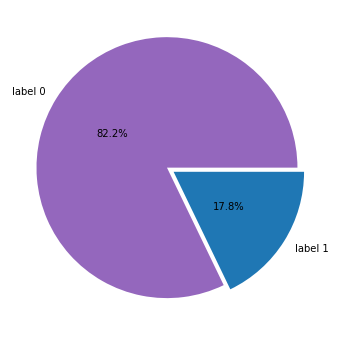

In [10]:
pie, ax = plt.subplots(figsize=[10,6])
colors = ['tab:purple', 'tab:blue']
labels = 'label 0', 'label 1'
plt.pie(x=train_set['label'].value_counts(), autopct="%.1f%%", colors = colors, explode=[0.03]*2, labels=labels, pctdistance=0.5);

### Exploring the numeric features:

In [11]:
numeric_features = classify_features(train_set)['numerical']
train_set_numeric = train_set[numeric_features]
train_set_numeric.head()

,0,3,4,5,7,9,10,11,13,14,17,20
0,1.0,0.828866,216.0,4.846091,50.0,161.714226,0.0,85.964376,2.0,414.0,2.191401,15.921017
1,8.0,8.981168,46.0,7.324911,270.0,328.559851,0.0,294.552881,3.0,63.0,3.811778,47.567140
2,1.0,1.458061,3304.0,7.548887,200.0,298.775554,0.0,317.615920,1.0,218.0,4.284457,10.522228
3,1.0,2.753682,212.0,8.200746,170.0,285.342907,0.0,181.773337,2.0,NaN,4.680751,21.185050
4,1.0,4.496872,1050.0,5.071094,260.0,328.464688,0.0,454.058222,3.0,293.0,2.740114,47.491164


#### showing some statistics about the numeric features:

In [12]:
train_set_numeric.describe()

,0,3,4,5,7,9,10,11,13,14,17,20
count,21858.000000,21826.000000,21906.000000,21871.000000,21911.000000,21892.000000,21828.000000,21860.000000,21891.000000,17946.000000,21830.000000,21930.000000
mean,2.709443,4.204116,1383.256596,6.589936,157.450596,256.617674,0.608164,268.845882,2.063816,276.022010,3.647972,26.278887
std,2.976380,3.752786,3030.087625,0.921664,83.121658,71.635412,1.893069,183.952200,0.784205,274.575423,0.746277,20.111219
min,1.000000,-11.138786,-8019.000000,3.776680,10.000000,-1.892158,0.000000,0.003898,0.000000,0.000000,1.939095,-54.438941
25%,1.000000,1.605409,80.000000,5.901285,80.000000,209.751981,0.000000,119.317515,2.000000,108.000000,3.036520,12.679984
50%,2.000000,4.190917,470.000000,6.517118,160.000000,277.786998,0.000000,242.093814,2.000000,191.000000,3.535312,26.477637
75%,3.000000,6.811247,1472.750000,7.246177,210.000000,306.584649,0.000000,388.855035,3.000000,342.000000,4.150667,39.945262
max,51.000000,17.647593,102127.000000,10.303540,310.000000,347.191571,41.000000,1081.031042,3.000000,4918.000000,7.141043,102.590418


#### Plotting the distribution for the numeric features:

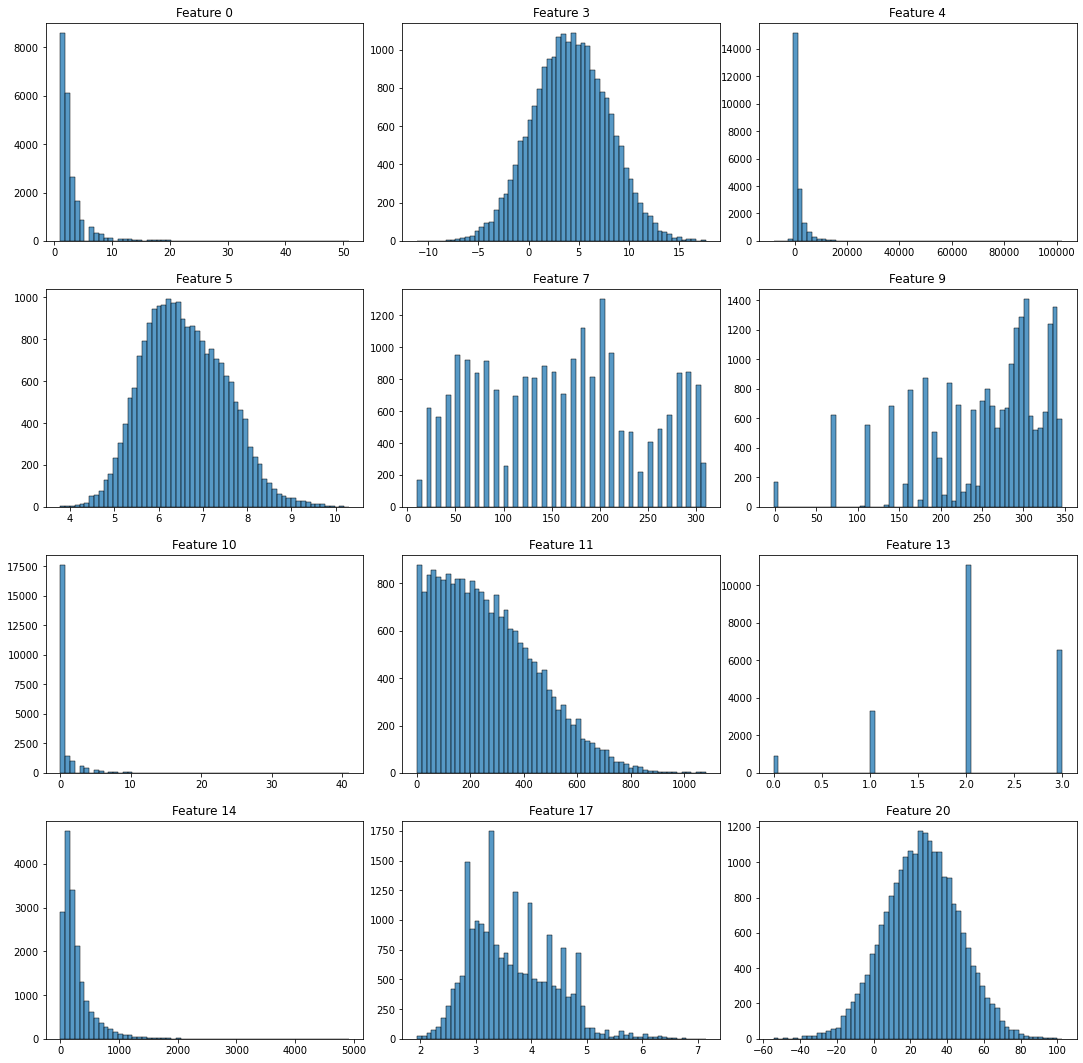

In [13]:
def num_dist(df):
    feature_classes = classify_features(df)
    numeric_features = feature_classes.get("numerical")
    f, axes = plt.subplots(4,3, figsize=(16,10))
    f.tight_layout()
    axes = axes.flatten()
    for i, feature in enumerate(numeric_features):
        f.set_figheight(15)
        f.set_figwidth(15)
        sns.histplot(data=df[feature], bins=60, ax=axes[i]).set(title='Feature {}'.format(feature), xlabel=None, ylabel=None)

num_dist(train_set)

#### Plotting the boxplots for each numeric feature:

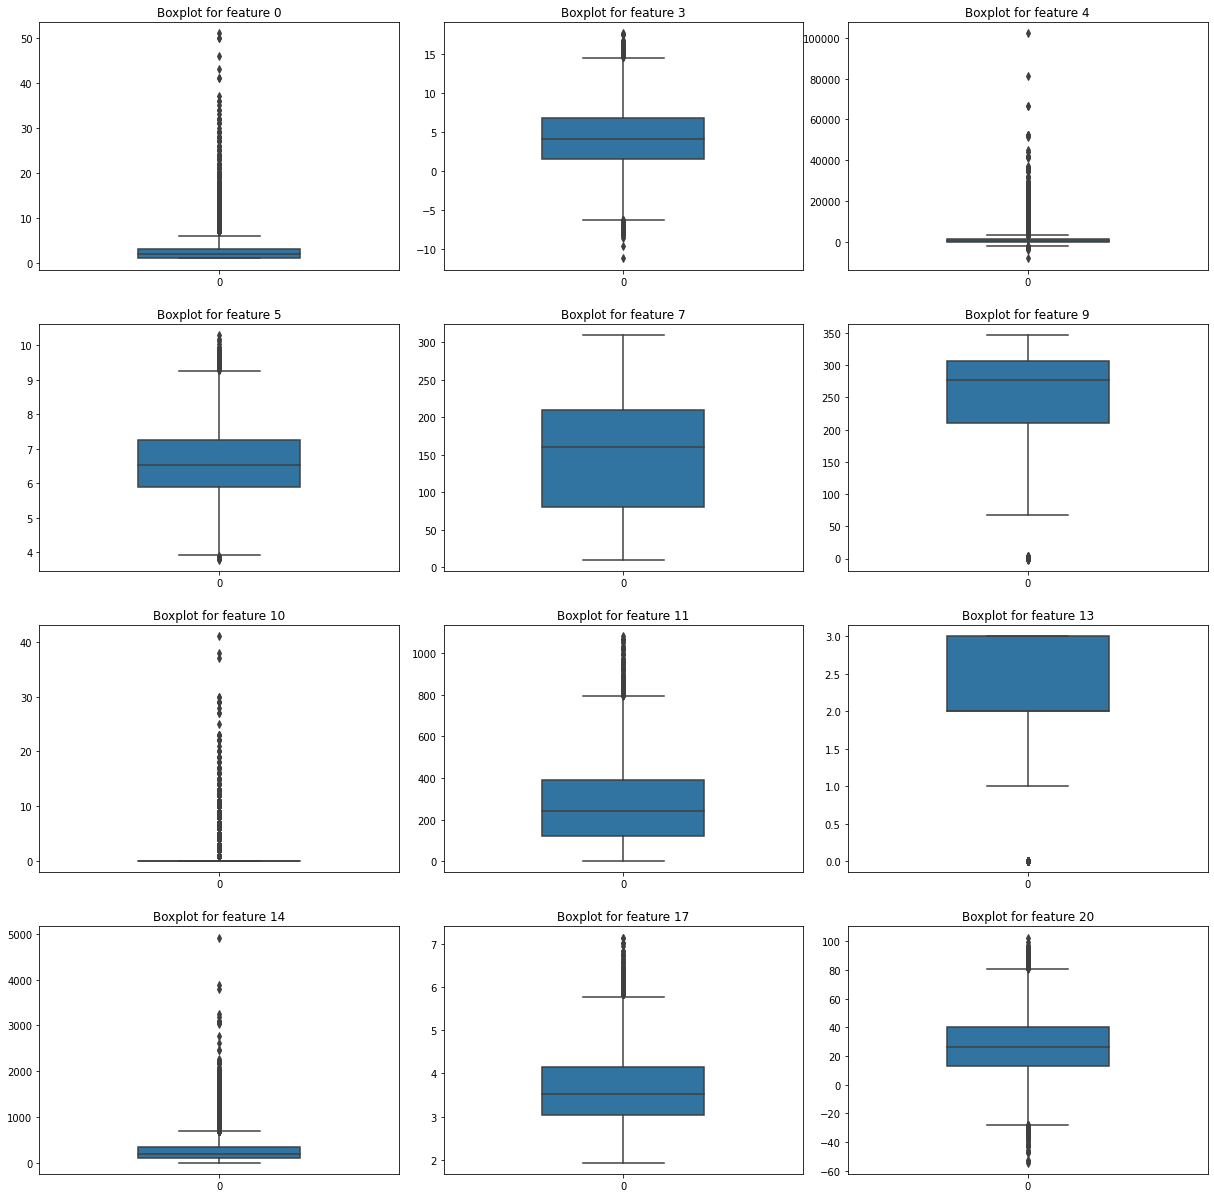

In [14]:
def box_plot(df):
    feature_classes = classify_features(df)
    numeric_features = feature_classes.get("numerical")
    f, axes = plt.subplots(4,3, figsize=(16,10))
    f.tight_layout()
    axes = axes.flatten()
    for i, feature in enumerate(numeric_features):
        f.set_figheight(17)
        f.set_figwidth(17)
        sns.boxplot(data=df[feature], orient='v', width=0.45, ax=axes[i]).set(title='Boxplot for feature {}'.format(feature))
        
box_plot(train_set)


#### Plotting the correlation matrix for the features:

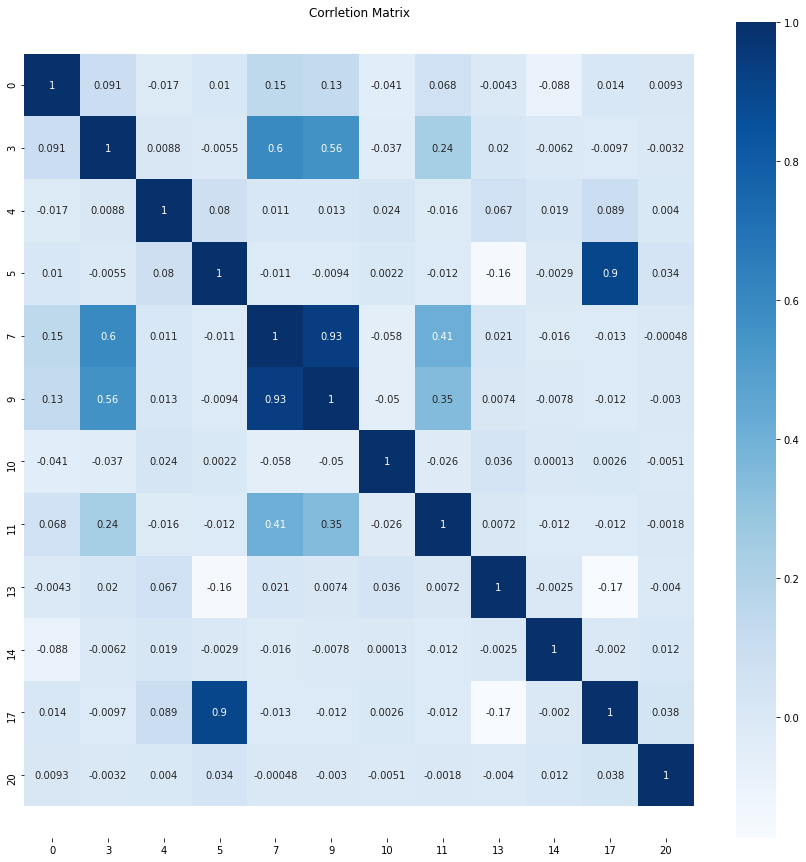

In [15]:
def cor_map(df):
    fig, ax =plt.subplots(figsize=(15, 15))
    corr_mat = df.corr()
    sns.heatmap(corr_mat, annot=True, cmap="Blues")
    bottom, top = plt.ylim()                                              
    bottom += 0.5                                                      
    top -= 0.5                                                      
    plt.ylim(bottom, top)                                                 
    ax.set_title('Corrletion Matrix')                                       
    plt.show()
    # Select upper triangle of correlation matrix
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
    # Find index of feature columns with correlation greater than 0.85
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    if to_drop != []:
        print ("Correlated Features:", to_drop)
cor_map(train_set_numeric)

### Exploring the categorical and binary features:

In [16]:
binary_features = classify_features(train_set)['binary']
train_set_binary = train_set[sorted(binary_features, key=lambda x: int(x))]
train_set_binary.head()

,8,15
0,0,0.0
1,0,0.0
2,1,0.0
3,0,0.0
4,1,0.0


In [17]:
cat_features = classify_features(train_set)['categorical'][:-1]  # without the label column which has already been explored 
train_set_cat = train_set[sorted(cat_features, key=lambda x: int(x))]
train_set_cat.head()

,1,2,6,12,16,18,19
0,a,-1d,K,n,S,a8,NaN
1,a,-1d,A,n,M,a8,NaN
2,a,-1d,D,n,M,a4,NaN
3,b,-1d,E,y,D,a7,NaN
4,unknown,-1d,B,n,S,a5,NaN


#### Plotting the distribution for the binary and categorical features:

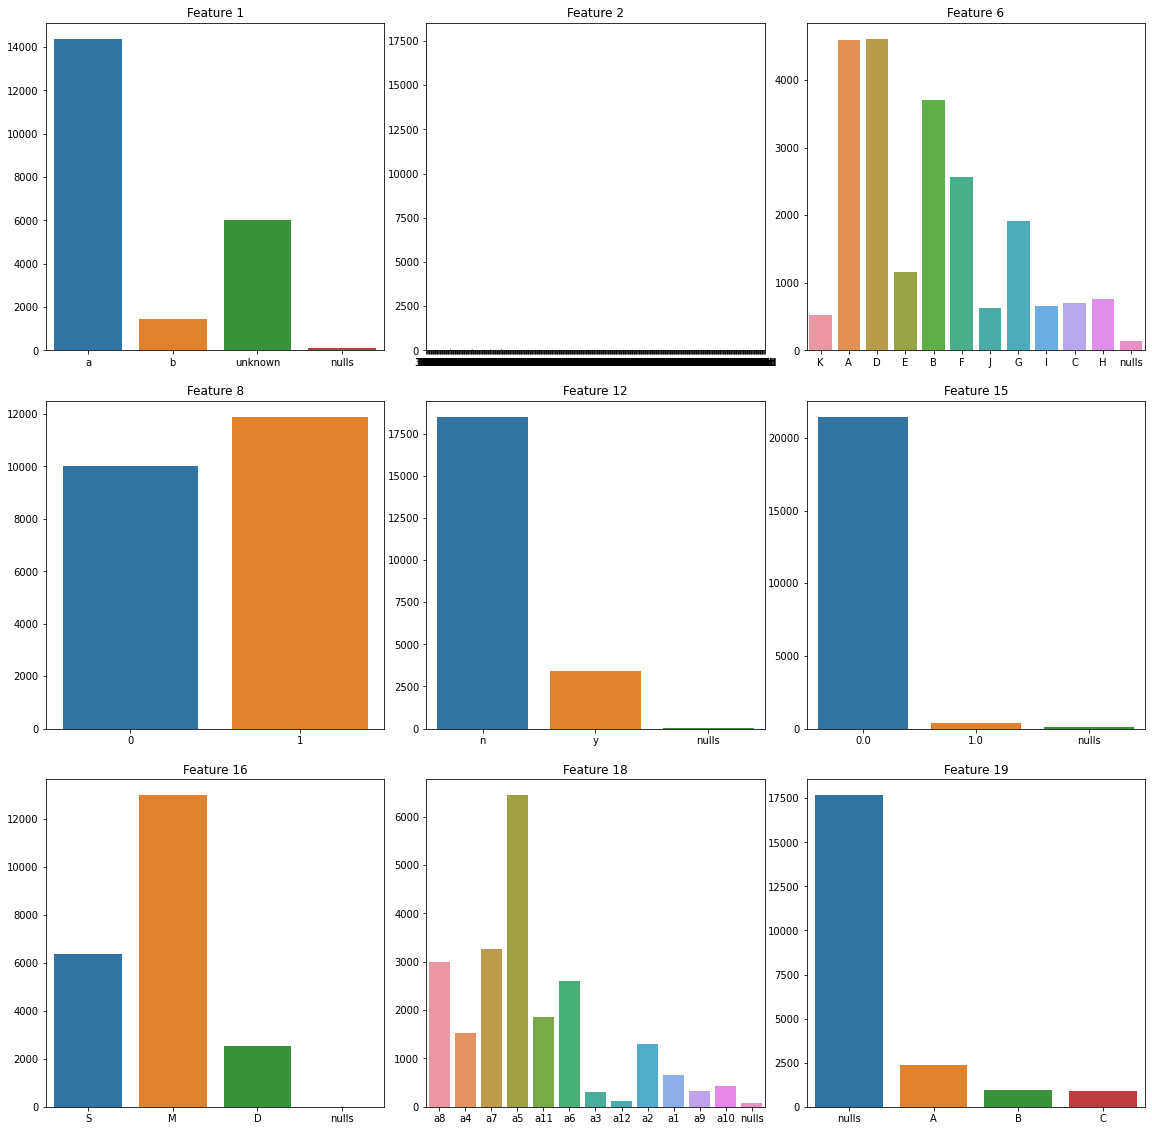

In [18]:
def cat_bin_dist(df):
    cat_features = classify_features(train_set)['categorical'][:-1]
    binary_features = classify_features(train_set)['binary']
    cat_bin_features = sorted(cat_features + binary_features, key=lambda x: int(x))
    f, axes = plt.subplots(3,3, figsize=(16,10))
    f.tight_layout()
    axes = axes.flatten()
    for i, feature in enumerate(cat_bin_features):
        f.set_figheight(16)
        f.set_figwidth(16)
        sns.countplot(x=df[feature].fillna('nulls'), ax=axes[i]).set(title='Feature {}'.format(feature), xlabel=None, ylabel=None)

cat_bin_dist(train_set)

Pre processing

In this stage we will choose the best pre processing option

In [19]:
# We chose the logistic_regression classifer to see which data set gives the best AUC score
def choose_best_preprocess():
    df = pd.read_csv('train.csv')
    df = basic_process(df, train=True)
    labels = df['label']
    final_data = []
    encoder1 = OneHotEncoder()
    encoder2 = OneHotEncoder()
    data_sets = [encoder1.fit_transform(df.copy()), encoder2.fit_transform(process_feature_selection(df.copy()))]

    #imputers = [IterativeImputer(),SimpleImputer(strategy='median'),DistributionImputer(),ChoiceImputer()]
    imputers = [SimpleImputer(strategy='median'),DistributionImputer(),ChoiceImputer()] 

    explained_var = [0.9, 0.95, 0.98]
    for data_set in data_sets:
        for imputer in imputers:
            feature_names = list(data_set.columns.values)  # save column names
            data_set = pd.DataFrame(imputer.fit_transform(data_set))  # impute data
            data_set = data_set.set_axis(feature_names, axis=1, inplace=False)  # rename columns after imputing
            scaler = CustomMinMax()
            data_set = pd.DataFrame(scaler.fit_transform(data_set), index=data_set.index,
                                    columns=data_set.columns)  # scale data
            for var in explained_var:
                pca = PCA(var, svd_solver='full')
                data = pca.fit_transform(data_set.drop(columns=['label'], axis=1))
                final_data.append(pd.DataFrame(data))


    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    pp_option = []
    train_pp_option = []
    clf = logistic_regression
    for i, df in enumerate(final_data):
        scores = []
        train_scores = []
        # the X axis (average fpr)
        avg_fpr_test = np.linspace(0, 1, 100)
        # the Y axis (average tpr)
        avg_tpr_test = np.linspace(0, 1, 100)

        avg_fpr_train = np.linspace(0, 1, 100)
        avg_tpr_train = np.linspace(0, 1, 100)

        tprs_test = np.linspace(0, 0, 100)
        tprs_train = np.linspace(0, 0, 100)
        # Initialize the mean TPR
        mean_tpr = 0.0
        # Creates an array of 100 numbers between 0 and 1 in equal jumps
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        base_fpr = np.linspace(0, 1, 100)
        for train_index, validate_index in kf.split(df):
            train = df.iloc[train_index]  # get rows by index list, drop label column
            validate = df.iloc[validate_index]
            train_label = np.array(labels.iloc[train_index])
            validate_label = np.array(labels.iloc[validate_index])

            clf.fit(train, train_label)
            predictions = clf.predict_proba(validate)
            predicted_labels = clf.predict(validate)
            train_predictions = clf.predict_proba(train)
            train_predicted_labels = clf.predict(train)

            score_validate = log_loss(validate_label, predicted_labels)
            score_train = log_loss(train_label,train_predicted_labels)
            print(f'score_validate is {score_validate}')
            print(f'score_train is {score_train}')
            fpr, tpr, threshold = roc_curve(validate_label, predictions[:, 1])
            fpr_train, tpr_train, thresholds_train = roc_curve(train_label, train_predictions[:,1])
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
            scores.append(roc_auc_score(validate_label, predictions[:, 1]))
            train_scores.append(roc_auc_score(train_label, train_predictions[:, 1]))

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)

        avg_auc_train = auc(base_fpr, mean_tprs)

        pp_option.append((i, sum(scores) / len(scores)))

        train_pp_option.append((i, sum(train_scores) / len(train_scores)))
    print(pp_option)
    print(train_pp_option)
    print(f'Best set option is no. {sorted(pp_option, key=lambda x: x[1], reverse=True)[0][0]}')

In [20]:

train_df = pd.read_csv('train.csv')
train_df = basic_process(train_df, train=True)
labels = train_df['label']
train_df.drop(columns=['label'], axis=1, inplace=True )
encoder = OneHotEncoder()
imputer = SimpleImputer()
#imputer = IterativeImputer(random_state=0)
scaler = CustomMinMax()
pca = PCA(0.95, svd_solver='full')

train_df = encoder.fit_transform(train_df)
feature_names = list(train_df.columns.values)  # save column names
train_df = pd.DataFrame(imputer.fit_transform(train_df))  # impute data
train_df = train_df.set_axis(feature_names, axis=1, inplace=False)  # rename columns after imputing

train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index,
                        columns=train_df.columns)  # scale data

train_df = pd.DataFrame(pca.fit_transform(train_df))

# Classifiers Assesment

ANN classifer's Confusion Matrix


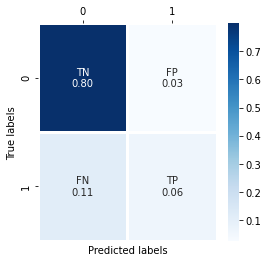



Checking Overfitting for classifier MLPClassifier..


The mean AUC for validation is 0.886
The mean AUC for train is 0.89
AUC diffrence of 0.4%


The mean Log loss for validation is 0.293
The mean Log loss for train is 0.289
Log loss diffrence of 0.40000000000000036%


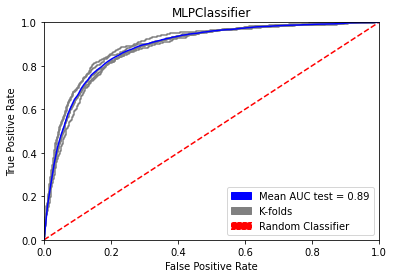



Checking Overfitting for classifier KNeighborsClassifier..


The mean AUC for validation is 0.818
The mean AUC for train is 0.832
AUC diffrence of 1.4000000000000001%


The mean Log loss for validation is 0.36
The mean Log loss for train is 0.349
Log loss diffrence of 1.100000000000001%


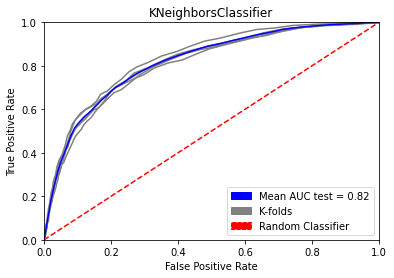



Checking Overfitting for classifier LogisticRegression..


The mean AUC for validation is 0.875
The mean AUC for train is 0.878
AUC diffrence of 0.3%


The mean Log loss for validation is 0.306
The mean Log loss for train is 0.303
Log loss diffrence of 0.30000000000000027%


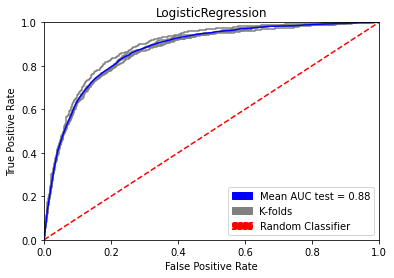

In [ ]:


classifiers = [ann, knn, logistic_regression, svm]
printed_confusion_mat = False
for i, clf in enumerate(classifiers):
    clf_name = clf.__class__.__name__
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    tprs_test = np.linspace(0, 0, 100)
    tprs_train = np.linspace(0, 0, 100)
    # Initialize the mean TPR
    mean_tpr = 0.0
    # Creates an array of 100 numbers between 0 and 1 in equal jumps
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    fpr_tprs = []
    base_fpr = np.linspace(0, 1, 100)
    validate_scores = []
    validate_log = []
    train_log = []
    train_scores = []
    for train_index, validate_index in kf.split(train_df):
        train = train_df.iloc[train_index]  # get rows by index list, drop label column
        validate = train_df.iloc[validate_index]
        train_label = np.array(labels.iloc[train_index])
        validate_label = np.array(labels.iloc[validate_index])

        clf.fit(train, train_label)
        predictions = clf.predict_proba(validate)
        predicted_labels = clf.predict(validate)
        train_predictions = clf.predict_proba(train)
        train_predicted_labels = clf.predict(train)


        logloss_validate = log_loss(validate_label, predictions)
        logloss_train = log_loss(train_label, train_predictions)
        auc_validate = (roc_auc_score(validate_label, predictions[:, 1]))
        auc_train = (roc_auc_score(train_label, train_predictions[:, 1]))
        
  
        fpr, tpr, threshold = roc_curve(validate_label, predictions[:, 1])
        fpr_train, tpr_train, thresholds_train = roc_curve(train_label, train_predictions[:, 1])

        fpr_tprs.append((fpr, tpr))
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        
        validate_scores.append(roc_auc_score(validate_label, predictions[:, 1]))
        train_scores.append(roc_auc_score(train_label, train_predictions[:, 1]))
        
        validate_log.append(logloss_validate)
        train_log.append(logloss_train)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)

    
    if not printed_confusion_mat:
        print(f'ANN classifer\'s Confusion Matrix')
        confusion_mat = ConfusionMatrix(clf_name, validate_label, predicted_labels)
        confusion_mat.plot()
        printed_confusion_mat = True
 
    
    mean_auc_validate = round(sum(validate_scores) / len(validate_scores),3)
    mean_auc_train = round(sum(train_scores) / len(train_scores),3)
    auc_diff = round(mean_auc_train-mean_auc_validate,3)
    mean_log_validate = round(sum(validate_log) / len(validate_log),3)
    mean_log_train = round(sum(train_log) / len(train_log),3)
    auc_diff = round(mean_auc_train-mean_auc_validate,3)
    log_diff = round(mean_log_train-mean_log_validate,3)
    print('\n')
    print(f'Checking Overfitting for classifier {clf_name}..')
    print('\n')
    print(f'The mean AUC for validation is {mean_auc_validate}')
    print(f'The mean AUC for train is {mean_auc_train}')
    print(f'AUC diffrence of {abs(auc_diff)*100}%')
    print('\n')
    print(f'The mean Log loss for validation is {mean_log_validate}')
    print(f'The mean Log loss for train is {mean_log_train}')
    print(f'Log loss diffrence of {abs(log_diff)*100}%')
    auc_plot = AUC(clf_name, fpr_tprs, base_fpr, mean_tprs, mean_auc_validate)
    

# Data Leak - K-Fold check

We split the data before processing, to evalute our model in a more conservative way with 90% train, 10% validation

In [ ]:
df = pd.read_csv('train.csv')
kf = KFold(n_splits=10, random_state=None, shuffle=True)
auc_trains = []
auc_validates = []
clf_name = ann.__class__.__name__
for train_index, validate_index in kf.split(df):
    train_df = pd.DataFrame.reset_index(df.iloc[train_index], drop=True)
    train_df = basic_process(train_df, train=True)
    train_labels = train_df['label']

    validate_df = pd.DataFrame.reset_index(df.iloc[validate_index].drop(columns=['label'], axis=1), drop=True)
    validate_labels = df.iloc[validate_index]['label']
    encoder = OneHotEncoder()
    #imputer = IterativeImputer(random_state=0)
    imputer = SimpleImputer(strategy='median')
    #imputer = ChoiceImputer()
    #scaler = MinMaxScaler()
    scaler = CustomMinMax()
    pca = PCA(0.95, svd_solver='full')
    train_df.drop(columns=['label'], axis=1, inplace=True)
    train_df = encoder.fit_transform(train_df)
    feature_names = list(train_df.columns.values)  # save column names
    train_df = pd.DataFrame(imputer.fit_transform(train_df))  # impute data
    train_df = train_df.set_axis(feature_names, axis=1, inplace=False)  # rename columns after imputing

    train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index,
                            columns=train_df.columns)  # scale data
    train_df = pca.fit_transform(train_df)
    train_df = pd.DataFrame(train_df)
    ann.fit(train_df, train_labels)

    # process the validate df

    validate_df = basic_process(validate_df)
    validate_df = encoder.transform(validate_df)
    feature_names = list(validate_df.columns.values)  # save column names
    validate_df = pd.DataFrame(imputer.transform(validate_df))
    validate_df = validate_df.set_axis(feature_names, axis=1, inplace=False)  # rename columns after imputing
    validate_df = pd.DataFrame(scaler.transform(validate_df), index=validate_df.index,
                            columns=validate_df.columns)  # scale data
    validate_df = pca.transform(validate_df)
    validate_df = pd.DataFrame(validate_df)

    # make predictions

    validate_predictions = ann.predict_proba(validate_df)
    train_predictions = ann.predict_proba(train_df)
    predicted_labels = ann.predict(validate_df)
    train_predicted_labels = ann.predict(train_df)

    auc_validate = (roc_auc_score(validate_labels, validate_predictions[:, 1]))
    auc_train = (roc_auc_score(train_labels, train_predictions[:, 1]))
    auc_validates.append(auc_validate)
    auc_trains.append(auc_train)
    
mean_auc_validate = round(sum(auc_validates) / len(auc_validates),3)
mean_auc_train = round(sum(auc_trains) / len(auc_trains),3)
auc_diff = mean_auc_validate - mean_auc_train
print(f'Checking Overfitting for classifier {clf_name}..')
print('\n')
print(f'The mean AUC for validation is {mean_auc_validate}')
print(f'The mean AUC for train is {mean_auc_train}')
print(f'AUC diffrence of {abs(auc_diff)*100}%')


# Part 5 - Making the predictions

Now we've assessed our model preformance, we will create the predictions for our test set.

In [ ]:
clf = ann
train_df = pd.read_csv('train.csv')
train_df = basic_process(train_df, train=True)
labels = train_df['label']
train_df.drop(columns=['label'], axis=1, inplace=True )
encoder = OneHotEncoder()
imputer = IterativeImputer(random_state=0)
scaler = CustomMinMax()
pca = PCA(0.95, svd_solver='full')

train_df = encoder.fit_transform(train_df)
feature_names = list(train_df.columns.values)  # save column names
train_df = pd.DataFrame(imputer.fit_transform(train_df))  # impute data
train_df = train_df.set_axis(feature_names, axis=1, inplace=False)  # rename columns after imputing

train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index,
                        columns=train_df.columns)  # scale data

train_df = pd.DataFrame(pca.fit_transform(train_df))

clf.fit(train, train_label)


test_df = pd.read_csv("test_without_target.csv")
test_df = basic_process(test_df)
test_df = encoder.transform(test_df)
feature_names = list(test_df.columns.values)  # save column names
test_df = pd.DataFrame(imputer.transform(test_df))
test_df = test_df.set_axis(feature_names, axis=1, inplace=False)  # rename columns after imputing
test_df = pd.DataFrame(scaler.transform(test_df),
                       index=test_df.index,
                        columns=test_df.columns)  # scale data
test_df = pca.transform(test_df)
test_df = pd.DataFrame(test_df)

predicted_probas = clf.predict_proba(test_df)[:, 1]
fieldnames = ['Sample', 'pred_proba']
with open('predictions.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for i, prediction in enumerate(predicted_probas):
        writer.writerow({'Sample': i, 'pred_proba': prediction})


In [ ]:

# We tried various combinations of feature selection, no feature selection, imputers and PCA to see which one is the best.
# We chose the ANN classifer to see which data set gives the best AUC score
